## Ejercicio 1.2 Implementar modelo de sentiment Analysis con algún algoritmo de Deep Learning
Como se comentó en el notebook [Tratamiento da datos inicial](00_1_AnalisisDataset1.ipynb) ya tenemos un dataset con una limpieza inicial, también hemos implementado un modelo de Machine Learning Clásico en el [Notebook](01_1_ML_Clasico.ipynb).

En este notebook toca implementar un modelo de Deep Learning sobre el mismo dataset y comparar los resultados con los que ofrece Machine Learning.

Después de cargar el dataset, haremos la tokenización, necesaria para crear un modelo de Deep Learning.

In [1]:
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import nltk
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Permitir ver columnas completas
pd.set_option('display.max_colwidth', None)

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"

# Comando nvidia-smi para ver la lista de GPU

set_session(tf.Session(config=config))  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [3]:
# Función para cargar dataframe
def load_data(ruta, nombre):
    path = os.path.join(ruta, nombre)    
    return pd.read_csv(path, encoding="ISO-8859-1")

In [4]:
# Carga de datos
df = load_data('data', 'dataset_1_limpieza_inicial.csv')
df.head()

,Sentiment,SentimentText
0,0,sad friend
1,0,missed new moon trailer
2,1,oh my god already
3,0,im sooo im gunna cry i have dentist since get crown put mins
4,0,think mi boyfriend cheating trending topic


In [39]:
from keras.layers import Conv1D, Conv2D, SimpleRNN, LSTM, Dense, Dropout, CuDNNLSTM, Embedding, Flatten, Input, Lambda
from keras.models import Sequential, Model
from collections import Counter

## Tokenización

In [21]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [20]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Formar dataset con la X y la Y
dataset = []

for row in df.iterrows():
    ix, data = row
    dataset.append((data[1], data[0]))

# Tokenizamos
tokens = []
tokenized = []

for x, y in dataset: 
    x_t = nlp(x)
    toks = [t.text for t in x_t]
    tokens += toks
    tokenized.append((toks, y))

# Crear vocabulario
vocab_counter = Counter(tokens)
vocab = set(tokens)
print('Núm de features a usar:', len(vocab))
print(len(tokenized))

Núm de features a usar: 21759
98731


In [22]:
# Longitud máxima del documento
maxlen = max([len(x) for x, _ in tokenized])
maxlen

68

In [23]:
# Longitud de todos los documentos
lens = [len(x) for x, _ in tokenized]

# Calculamos mediana, media y maxima longitud
median = np.median(np.array(lens))
mean = np.mean(np.array(lens))
maxlen = int(median)*2
print('Mediana: ', median)
print('Media: ', mean)
print('Maxlen ', maxlen)

Mediana:  7.0
Media:  7.382645774883269
Maxlen  14


In [24]:
# Al igual que se hizo en clase, nos quedamos con el doble de la mediana como longitud máxima, filtramos para obtener documentos con longitud menor que 14
tokenized_filtered = [(x, y) for x, y in tokenized if len(x) < maxlen]
len(tokenized_filtered)

89207

In [26]:
# Asignamos un identificador a cada palabra del vocabulario
w2id = {k:i for i, k in enumerate(vocab)}
w2id['<UNK>'] = len(w2id)

In [27]:
# Devinimos nuestras etiquetas, para este caso, tenemos 2 (0 negativo y 1 positivo) 
labels = [
    'Negativo',
    'Positivo'
]

In [28]:
l2id = {label:i for i, label in enumerate(labels)}
l2id

{'Negativo': 0, 'Positivo': 1}

## Padding + Input preparation
Preparamos las etiquetas y las frases transformándolas a índices. Solo tenemos en cuenta las palabras que han aparecido 5 o más veces.

In [29]:
input_ready = []
for x, y in tokenized_filtered:
    sentence = np.zeros((maxlen))
    label = np.zeros((len(labels)))
    label[int(y)-1] = 1
    for i, t in enumerate(x):
        sentence[i] = w2id[t] if t in vocab_counter and vocab_counter[t] >= 5 else w2id['<UNK>']
    input_ready.append((sentence,label))

input_ready[0][0].shape

(14,)

## División test y train

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_val_test(dataset, split = 0.2):
    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1337)

    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]

    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}

    return splits

In [33]:
split_dl = split_train_val_test(input_ready)

## Creación del modelo con embeddings

In [36]:
input_layer = Input(shape=(maxlen,))
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen)(input_layer)
dense_1 = Dense(300, activation='relu')(embedding)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(300, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrix=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 14, 100)           2176000   
_________________________________________________________________
dense_4 (Dense)              (None, 14, 300)           30300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 300)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 14, 300)           90300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 300)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 14, 2)             602       
Total para

Este modelo no me valdría por la salida que tiene. Tengo 2 etiquetas, la softmax final tiene que tener 2 etiquetas, y ahora me está generando por cada plabra una predicción diferente, y nosotros queremos una predicción por documento, así que generamos otro modelo.
## Deep averaging networks

In [41]:
from keras import backend as K

def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)
    # number of that rows are not all zeros
    n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)
    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False) / n
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    return (shape[0], shape[2])

In [48]:
input_layer = Input(shape=(maxlen,) )
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen,name='m_embedding')(input_layer)
doc_representation = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding)
dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 14)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 14, 100)           2176000   
_________________________________________________________________
embedding_average (Lambda)   (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
__________

## Entrenamiento del modelo

In [58]:
historico = model.fit(split_dl['train'][0], split_dl['train'][1], validation_data=(split_dl['test'][0], split_dl['test'][1]),
	epochs=200, batch_size=27)

- val_acc: 0.7399
Epoch 60/200
71365/71365 [==============================] - 17s 238us/step - loss: 0.4666 - acc: 0.8357 - val_loss: 0.9119 - val_acc: 0.7477
Epoch 61/200
71365/71365 [==============================] - 17s 235us/step - loss: 0.4736 - acc: 0.8352 - val_loss: 0.8561 - val_acc: 0.7468
Epoch 62/200
71365/71365 [==============================] - 17s 236us/step - loss: 0.4754 - acc: 0.8369 - val_loss: 0.9305 - val_acc: 0.7428
Epoch 63/200
71365/71365 [==============================] - 17s 236us/step - loss: 0.4749 - acc: 0.8362 - val_loss: 0.8766 - val_acc: 0.7404
Epoch 64/200
71365/71365 [==============================] - 17s 236us/step - loss: 0.4702 - acc: 0.8365 - val_loss: 0.9011 - val_acc: 0.7393
Epoch 65/200
71365/71365 [==============================] - 17s 234us/step - loss: 0.4793 - acc: 0.8359 - val_loss: 0.8558 - val_acc: 0.7367
Epoch 66/200
71365/71365 [==============================] - 17s 234us/step - loss: 0.4798 - acc: 0.8357 - val_loss: 0.8600 - val_acc: 0.

## Curva de pérdidas Train

Text(0, 0.5, 'Loss')

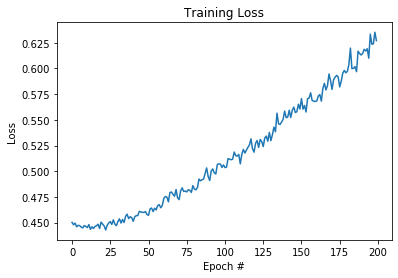

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 200), historico.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

## Curva de pérdidas Test

Text(0, 0.5, 'Loss')

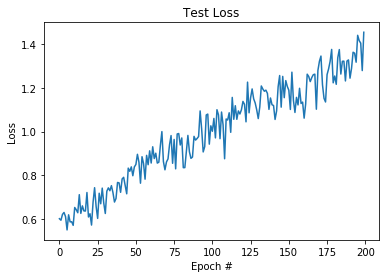

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 200), historico.history["val_loss"])
plt.title("Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

Al ver las curvas de pérdidas vemos que no convergen y que tienen muchas irregularidades, además, a partir de la época 10 el modelo deja de generalizar bien, por lo que empieza a entrar en overfitting.

Entrenamos el modelo hasta la época 8:

In [67]:
input_layer = Input(shape=(maxlen,) )
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen,name='m_embedding')(input_layer)
doc_representation = Lambda(mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding)
dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

historico = model.fit(split_dl['train'][0], split_dl['train'][1], validation_data=(split_dl['test'][0], split_dl['test'][1]),
	epochs=8, batch_size=27)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 14)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 14, 100)           2176000   
_________________________________________________________________
embedding_average (Lambda)   (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
__________

Text(0, 0.5, 'Loss')

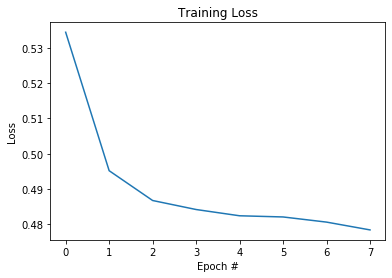

In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 8), historico.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

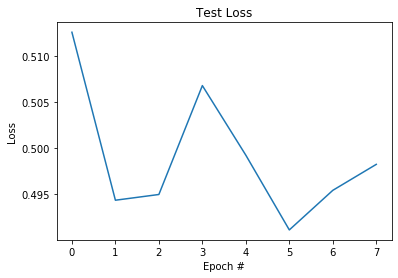

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 8), historico.history["val_loss"])
plt.title("Test Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

## Evaluar el modelo

In [70]:
scores = model.evaluate(split_dl['test'][0], split_dl['test'][1])
print("Accuracy: %.2f%%" % (scores[1]*100))

17842/17842 [==============================] - 1s 31us/step
Accuracy: 76.86%


## Probar el modelo
Probamos el modelo con los mismos tweets de pruebas del notebook de Machine Learning

In [72]:
y_pred_dl = model.predict(split_dl['test'][0])

## Matriz de confusión

In [74]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

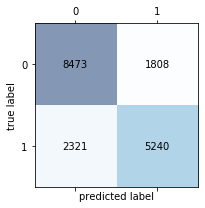

In [75]:
y_pred_test_dl = []
for a, b in y_pred_dl:
  if (a > 0.5):
    a = 1
  else:
    a = 0
  if (b > 0.5):
    b = 1
  else:
    b = 0

  if (len(y_pred_test_dl) == 0):
    y_pred_test_dl = np.array([[float(a), float(b)]])
  else:
    new_item = np.array([[float(a), float(b)]])
    y_pred_test_dl = np.concatenate((y_pred_test_dl, new_item), axis = 0)

from sklearn.metrics import confusion_matrix

# Matriz de confusión y metricas (Entrenamiento)
confmat = confusion_matrix(split_dl['test'][1].argmax(axis = 1), y_pred_test_dl.argmax(axis = 1))
plot_confusion_matrix(confmat)